# music-genre-classification

---
> **Preamble:** This notebook was adapted from an Introduction to Machine Learning course assignment. This notebook is intended to demonstrate a basic understanding of classification models and exploration of concepts in machine learning.
---

> **Goal:** To develop a music genre detection machine learning model using audio files (potentially) in real-time.

> **Objective:**: Using the GTZAN dataset to create a classifier that can classify what the music genre is playing! 🎷🎸🎹🎺
Develop a ‘baseline solution’ that uses a pre-trained classifier and fine-tuned it on the musical genre classification task using transfer learning.

> **Instructions:** The entire full notebook should run in approximately 120 minutes to run on T4 GPU. The solutions for this notebook are self-contained. This notebook was intended to be executed and tested on Google Colab. Using the commands: `runtime → run all`.

> **Dataset:** GTZAN Dataset.

Download from source: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download

Placed under `My Drive` in the Google Drive directory and renamed as `GTZAN Genre Collection.zip`

Music. Experts have been trying for a long time to understand sound and what differentiates one song from another. How to visualize sound. What makes a tone different from another? This data hopefully can allow doing just that.

- *genres original* - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)
- *images original* - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible.
- *2 CSV files* - Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file. The other file has the same structure, but the songs were split before into 3-second audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better.

> **Runtime Tips:** Select `Runtime -> Change Runtime Type` under `Hardware accelerator` and click on `CPU` or `T4 GPU`.


# 1. Initializations


In [ ]:
# For the optional portion at the end
# Packages are required for compiling and installing PyAudio,
# which allows for recording and playing audio in Python scripts
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

# For audio input and output in Python
!pip install PyAudio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libasound2-dev is already the newest version (1.2.6.1-1ubuntu1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 0s (541 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 121753 files and directories currently installed.)
Pre

In [ ]:
# General
import os
import zipfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For preproccessing
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# For modeling
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchsummary

# For metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# For cleaner stdout
import warnings
warnings.filterwarnings('ignore')

This code block will mount google drive.

*It will open a new window to get authorizations to use your Google Drive. Just follow the steps.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1.2 Create path

Change filepath to dataset as required.

In [ ]:
# Path for extractions
zip_file_paths = ['/content/drive/My Drive/GTZAN Genre Collection.zip',
                  '/content/drive/My Drive/GTZAN Genre Collection Spectrograms.zip']

dataset_dirs = ['/content/drive/My Drive/GTZAN Genre Collection',
                '/content/drive/My Drive/GTZAN Genre Collection Spectrograms']

for zip_file_path, dataset_dir in zip(zip_file_paths, dataset_dirs):
  if os.path.exists(zip_file_path):
    print(f"Extracting {zip_file_path} to {dataset_dir}")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(dataset_dir)
  else:
    print(f"Zip file {zip_file_path} does not exist.")

genres_original = f'{dataset_dirs[0]}/Data/genres_original/'
images_original = f'{dataset_dirs[0]}/Data/images_original/'

Extracting /content/drive/My Drive/GTZAN Genre Collection.zip to /content/drive/My Drive/GTZAN Genre Collection
Zip file /content/drive/My Drive/GTZAN Genre Collection Spectrograms.zip does not exist.


#### 1.3 Load the data and see how it looks

1.   Show how many categories/classes there are in the dataset using ```print()```
2.   Show how many samples are present in each category using ```print()```
2.   Plot the class distributions for the dataset using ```matplotlib```



In [ ]:
# Get a count of the samples

# Step 1: Categories/classes in the dataset
categories = list(os.listdir(genres_original))
print(categories)

# Create a dictionary to store data
data = {category: pd.Series(os.listdir(os.path.join(genres_original, category))) for category in categories}
lengths = {category: len(files) for category, files in data.items()}

# Create DataFrame
df = pd.DataFrame(data)

# Step 2: Samples present in each category
print("(samples, categories) =", df.shape) # (samples, categories)

# Step 3: Plot the class distributions for the dataset
def plot_class_distribution(data: dict, figsize: tuple=(8, 4)) -> None:
  """
  Plot the distribution of audio files by genre.

  Parameters:
    data (dict): A dictionary containing the distribution of audio files by
      genre. Keys represent genre names, and values represent the number of
      audio files for each genre.
    figsize (tuple): A tuple specifying the figure size (width, height).
      Default is (8, 4).

  Returns:
      None
  """
  # Calculate the length of audio files for each genre
  lengths = {category: len(files) for category, files in data.items()}

  # Create a bar plot
  plt.figure(figsize=figsize)
  plt.bar(lengths.keys(), lengths.values())

  # Set labels and title
  plt.xlabel('Genre')
  plt.ylabel('Number of Audio Files')
  plt.title('Distribution of Audio Files by Genre')

  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45)

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
(samples, categories) = (100, 10)


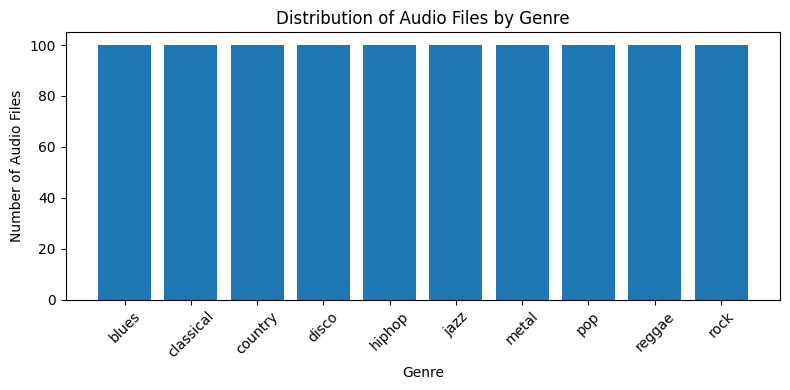

In [ ]:
# Plot the class distributions
plot_class_distribution(data)

In [ ]:
# Visualize the head of DataFrame
df.head()

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,blues.00000.wav,classical.00000.wav,country.00000.wav,disco.00000.wav,hiphop.00000.wav,jazz.00000.wav,metal.00000.wav,pop.00000.wav,reggae.00000.wav,rock.00000.wav
1,blues.00001.wav,classical.00001.wav,country.00001.wav,disco.00001.wav,hiphop.00001.wav,jazz.00001.wav,metal.00001.wav,pop.00001.wav,reggae.00001.wav,rock.00001.wav
2,blues.00002.wav,classical.00002.wav,country.00002.wav,disco.00002.wav,hiphop.00002.wav,jazz.00002.wav,metal.00002.wav,pop.00002.wav,reggae.00002.wav,rock.00002.wav
3,blues.00003.wav,classical.00003.wav,country.00003.wav,disco.00003.wav,hiphop.00003.wav,jazz.00003.wav,metal.00003.wav,pop.00003.wav,reggae.00003.wav,rock.00003.wav
4,blues.00004.wav,classical.00004.wav,country.00004.wav,disco.00004.wav,hiphop.00004.wav,jazz.00004.wav,metal.00004.wav,pop.00004.wav,reggae.00004.wav,rock.00004.wav


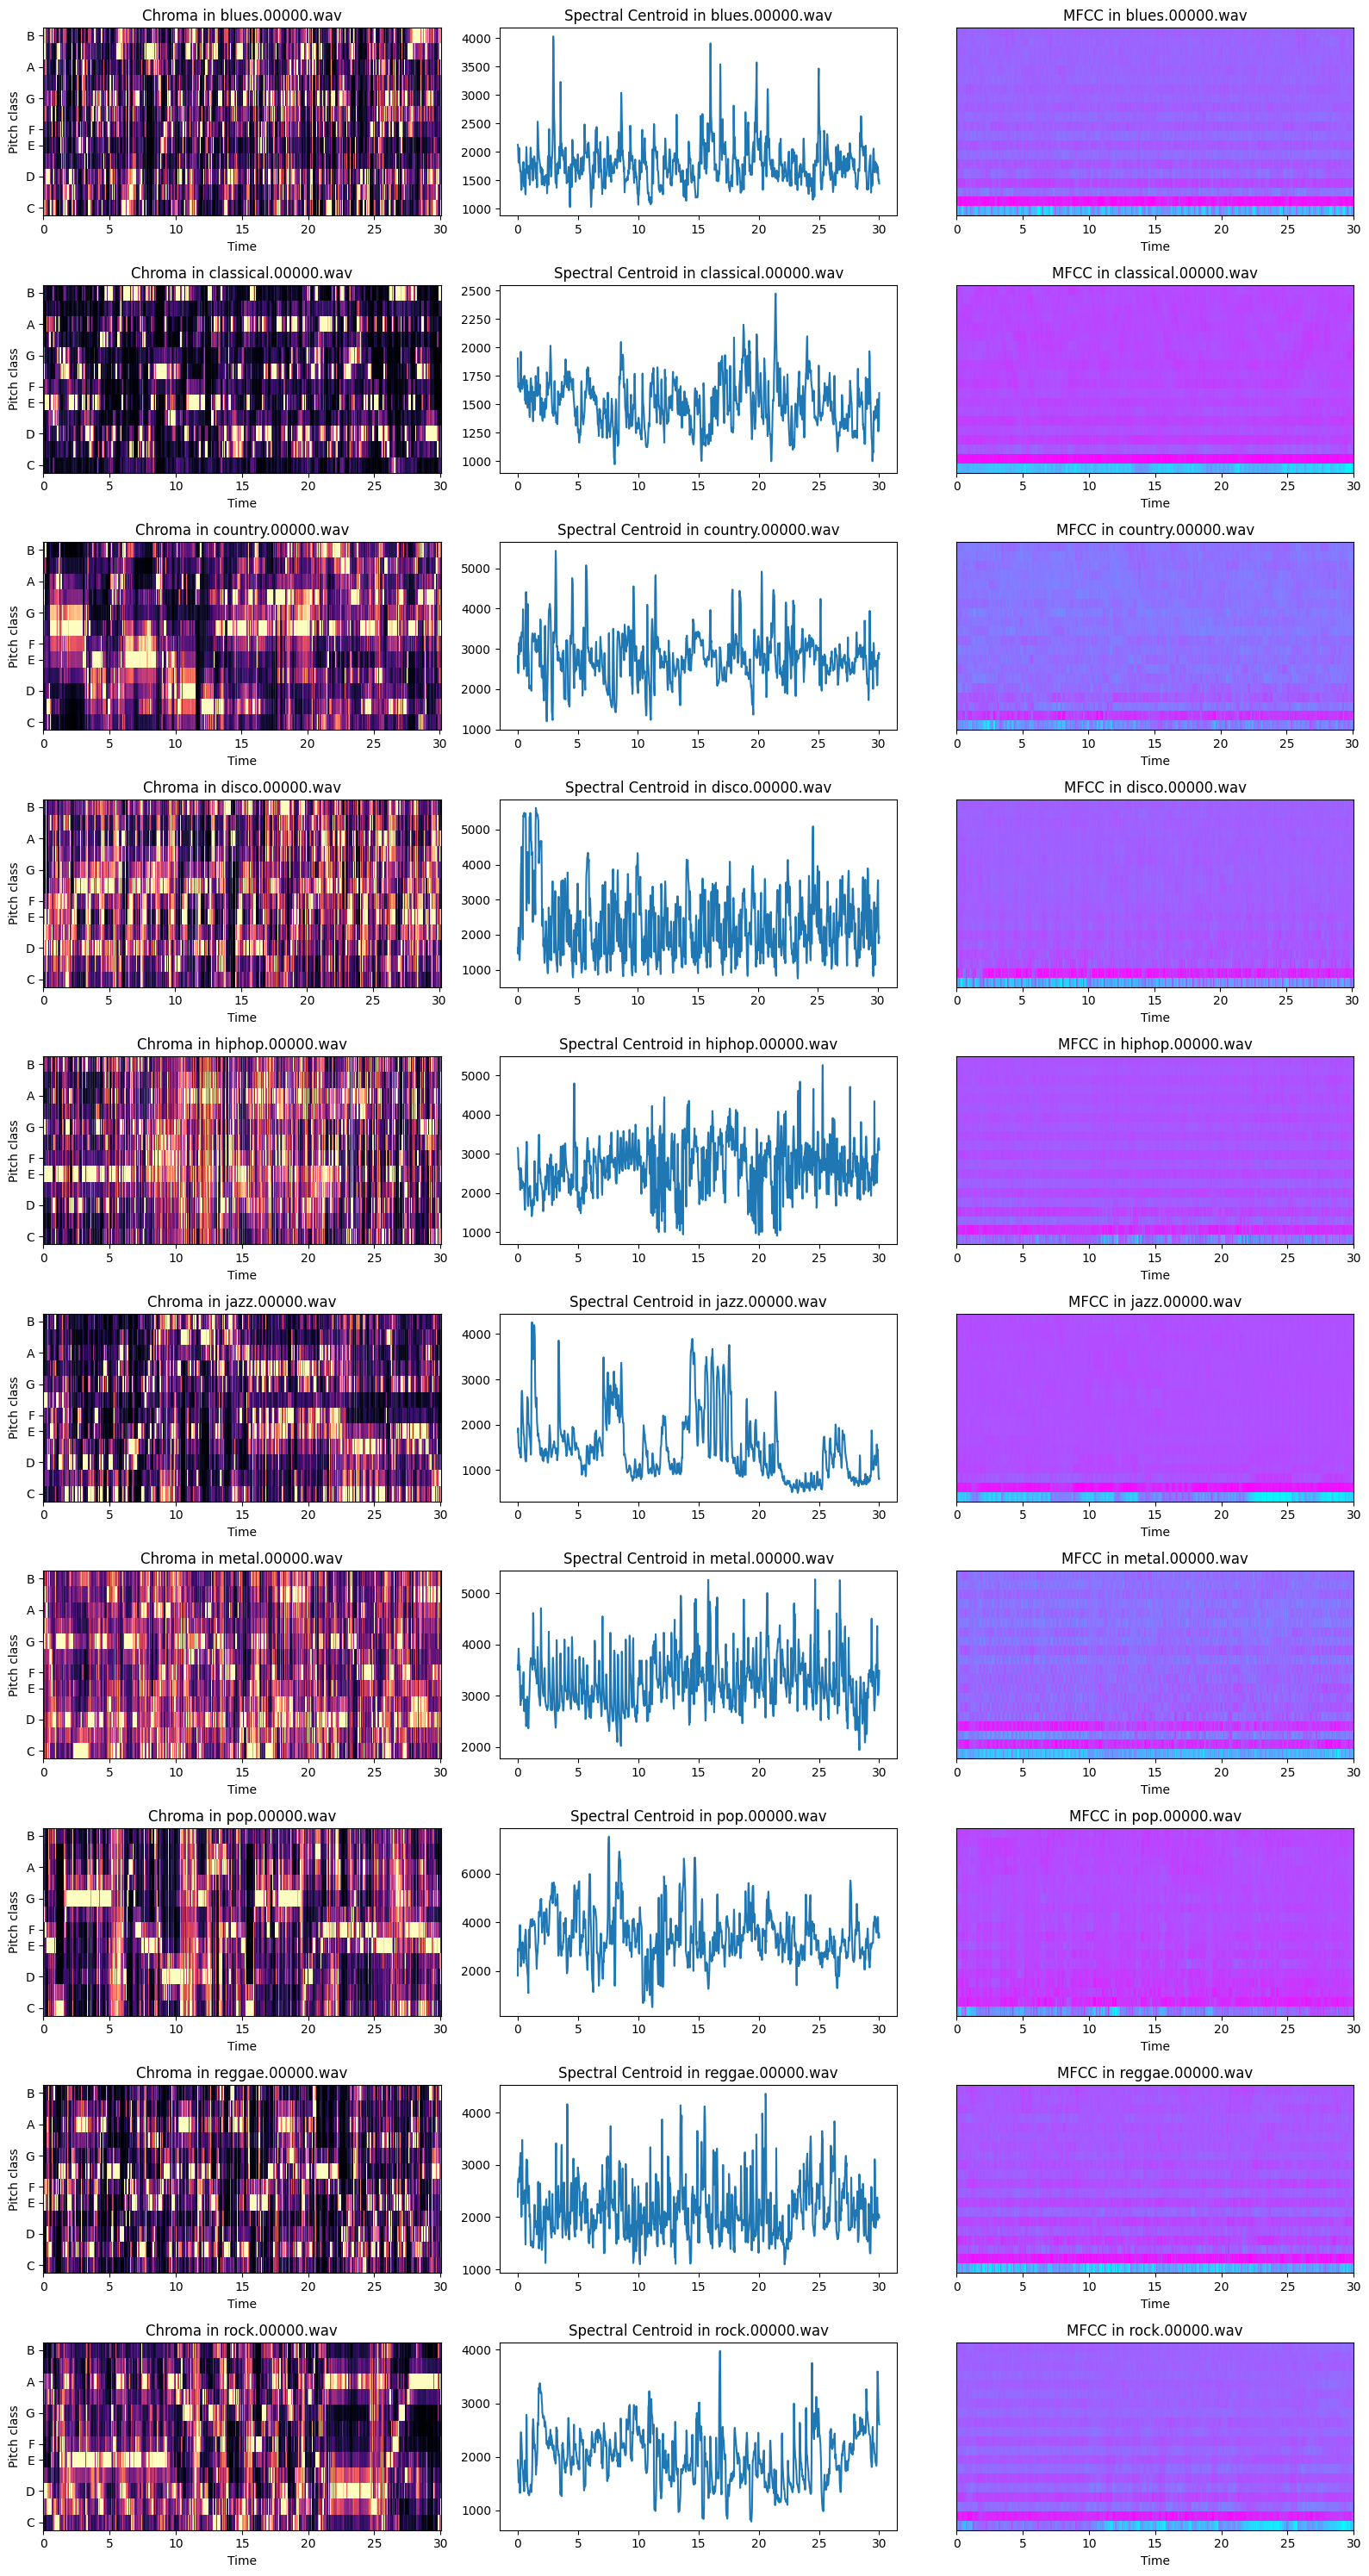

In [ ]:
# Any additional data visualizations or exploratory analysis
# This is optional, but highly recommended
def visualize_audio_features(data_path: str, categories: list) -> None:
  """
  Visualize some audio features including short-time Fourier transform chroma,
  spectral centroid, mel-frequency cepstral coefficients.

  Parameters:
    data_path (str): Path to the directory containing audio files.
    categories (list): List of category names.

  Returns:
    None
  """
  num_categories = len(categories)
  # Create subplots
  fig, axs = plt.subplots(num_categories, 3,
                          figsize=(16, num_categories * 3))

  # Iterate over each category
  for i, category in enumerate(categories):
    category_path = os.path.join(data_path, category)
    audio_files = [f for f in os.listdir(category_path)]
    audio_path = os.path.join(category_path, audio_files[0])
    y, sr = librosa.load(audio_path)

    # Extract Short-Time Fourier Transform Chroma feature
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    axs[i, 0].set_title(f'Chroma in {audio_files[0]}')
    librosa.display.specshow(chroma_stft,
                              y_axis='chroma',
                              x_axis='time',
                              ax=axs[i, 0])

    # Extract Spectral Centroid feature
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # Computing the time variable for visualization
    frames = range(len(spectral_centroid))
    # Converts frame counts to time (seconds)
    t = librosa.frames_to_time(frames)
    axs[i, 1].set_title(f'Spectral Centroid in {audio_files[0]}')
    axs[i, 1].plot(t, spectral_centroid)

    # Extract Mel-Frequency Cepstral Coefficients feature
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    axs[i, 2].set_title(f'MFCC in {audio_files[0]}')
    librosa.display.specshow(mfcc,
                              sr=sr,
                              x_axis='time',
                              cmap = 'cool',
                              ax=axs[i, 2])

  plt.tight_layout()
  plt.show()

# Data visualizations
visualize_audio_features(genres_original, categories)

In [ ]:
import IPython.display as ipd
# Note: The jazz.00054.wav recording is corrupted
# Reference: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/discussion/158649
ipd.Audio(f'{genres_original}/jazz/jazz.00054.wav')

# 2. Preprocessing

1. Create DataLoaders
2. Create train and test splits

Perform normalization/scaling or any additional proposed preproccessing here

In [ ]:
# For preprocessing and metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# For models and classifiers
from sklearn.base import ClassifierMixin
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

In [ ]:
# Any additional preproccessing

RANDOM_STATE = 42
SAMPLING_RATE = 22050

# Preliminary preprocessing during audio file loading
def preprocessing(audio_path: str) -> tuple:
  """
  Load audio file and perform preprocessing steps including resampling,
  converting to mono, and trimming leading/trailing silence.

  Parameters:
    audio_path (str): Path to the audio file.

  Returns:
    tuple: A tuple containing the preprocessed audio time series, y, and its
      sampling rate, sr. The preprocessed audio time series represents the
      waveform of the loaded audio after resampling, conversion to mono, and
      removal of leading and trailing silence. The sampling rate indicates the
      number of samples per second.
  """
  try:
    # Load audio file
    y, sr = librosa.load(audio_path)
    # Resample the audio
    y = librosa.resample(y, orig_sr=sr, target_sr=SAMPLING_RATE)
    # Convert an audio signal to mono by averaging samples across channels
    y = librosa.to_mono(y)
    # Trim leading and trailing silence
    y, _ = librosa.effects.trim(y)
  except:
    return None

  return y, sr


# Function to extract audio features from file
def extract_features(audio_file: str) -> dict:
  """
  Extract audio features from an audio file.

  Parameters:
    audio_file (str): Path to the audio file.

  Returns:
    features (dict): Dictionary containing extracted audio features.
      Keys are feature names and values are either float values or numpy arrays.
      Returns None if an error occurs during processing.
  """
  # Dictionary to store features
  features = {}

  try:
    # Load audio file
    y, sr = preprocessing(audio_file)

    # Compute chroma_stft feature
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_stft_mean'] = chroma_stft.mean(dtype=np.float64)

    # Compute spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['spectral_rolloff_mean'] = spectral_rolloff.mean(dtype=np.float64)

    # Compute spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = spectral_centroid.mean(dtype=np.float64)

    # Compute tempo
    tempo = librosa.feature.tempo(y=y, sr=sr)
    features['tempo'] = tempo.mean(dtype=np.float64)

    # Compute mfcc spectrogram feature
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    features['mfcc'] = mfcc.mean(dtype=np.float64)

  except Exception as e:
    # In case of error, return None
    return None

  return features

# Create a list to store features for each audio file
def create_data_list(categories: list, data_path: str) -> tuple:
  """
  Extracts features from audio files in the specified directories.

  Parameters:
    categories (list): List of categories or genres.
    genres_original (str): Path to the directory containing audio files
      categorized by genres.

  Returns:
    tuple: A tuple containing the list of features for each audio file and the
      list of column names.
  """
  # Create a list to store features for each audio file
  data_list: list = []

  # Feature names list
  feature_names: list = ['chroma_stft_mean',
                         'spectral_rolloff_mean',
                         'spectral_centroid_mean',
                         'tempo',
                         'mfcc']

  # DataFrame header
  columns: list = ['filename'] + feature_names + ['label']

  # Iterate over each category
  for i, category in enumerate(categories):
    # Iterate over each audio file
    for audio_file in tqdm(os.listdir(os.path.join(data_path, category)), leave=True, desc=category):
      audio_path: str = os.path.join(data_path, category, audio_file)
      try:
        audio_features: dict = extract_features(audio_path)
        if audio_features is not None:
          genre_label: str = category
          data_list.append([audio_file] + [audio_features[feat] for feat in feature_names] + [genre_label])
      except:
        continue

  return data_list, columns

In [ ]:
# Generate data list and labels for features extracted from audio file
data_list, labels = create_data_list(categories=categories,
                                     data_path=genres_original)

rock: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


In [ ]:
# Construct DataFrame of extracted audio features
df = pd.DataFrame(data_list, columns=labels)
data = df.iloc[0:, 1:]
# Visualize the DataFrame
data

,chroma_stft_mean,spectral_rolloff_mean,spectral_centroid_mean,tempo,mfcc,label
0,0.350128,3805.723030,1784.122641,123.046875,1.936640,blues
1,0.340849,3550.713616,1530.261767,107.666016,-0.057255,blues
2,0.363538,3042.410115,1552.832481,161.499023,1.032618,blues
3,0.404854,2184.879029,1070.153418,172.265625,0.068925,blues
4,0.308526,3579.957471,1835.128513,135.999178,-8.460349,blues
...,...,...,...,...,...,...
994,0.351977,4253.623647,2008.174521,103.359375,-1.727808,rock
995,0.398869,4149.171791,2006.827265,117.453835,-1.765299,rock
996,0.431980,4031.530224,2077.565822,129.199219,-2.667703,rock
997,0.362635,3015.597697,1398.649504,112.347147,-2.240276,rock


In [ ]:
# Any additional preproccessing
from sklearn import preprocessing

# Encoding categorical features
label_encoder = LabelEncoder()
y = data['label'] # genre label
y = label_encoder.fit_transform(y)
X = data.loc[:, data.columns != 'label'] # select all columns except labels
cols = X.columns

# Feature scaling
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# Create new DataFrame with the scaled data
X = pd.DataFrame(np_scaled, columns = cols)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(true_labels: list,
                          predicted_labels: list,
                          class_names: list) -> None:
  """
  Plots the confusion matrix.

  Parameters:
    true_labels (list): List of true labels.
    predicted_labels (list): List of predicted labels.
    class_names (list): List of class names.

  Returns:
    None
  """
  cm = confusion_matrix(true_labels, predicted_labels)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Reds', fmt='g',
              xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted labels')
  plt.ylabel('Actual labels')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

def model_assess(model: ClassifierMixin, title: str = "Default") -> None:
  """
  Trains the model on the training data, predicts labels for the test data,
  and evaluates the model's accuracy.

  Parameters:
      model (ClassifierMixin): The classifier model to be assessed.
      title (str, optional): Title to display for the accuracy score.

  Returns:
    None
  """
  # Split the data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

  # Train the model
  model.fit(X_train, y_train)

  # Predict labels for the test data
  predicted_labels = model.predict(X_test)

  # Plot confusion matrix
  # plot_confusion_matrix(y_test, predicted_labels, categories)

  # Evaluate the model's accuracy
  print('Accuracy', title, ':', accuracy_score(y_test, predicted_labels))

In [ ]:
# Initialize models
nb = GaussianNB()
sgd = SGDClassifier(max_iter=5000, random_state=RANDOM_STATE)
knn = KNeighborsClassifier(n_neighbors=20)
tree = DecisionTreeClassifier()
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=RANDOM_STATE)
svm = SVC(decision_function_shape="ovo")
lg = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial')
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgbrf = XGBRFClassifier(objective='multi:softmax')

classifiers = [nb, sgd, knn, tree, rforest, svm, lg, xgb, xgbrf]
titles = ['Naive Bayes',
          'Stochastic Gradient Descent',
          'K-Nearest Neighbour',
          'Decision Trees',
          'Random Forest',
          'Support Vector Machine',
          'Logistic Regression',
          'Cross Gradient Booster',
          'Cross Gradient Booster (Random Forest)']

for clf, title in zip(classifiers, titles):
  model_assess(clf, title)

Accuracy Naive Bayes : 0.31
Accuracy Stochastic Gradient Descent : 0.36
Accuracy K-Nearest Neighbour : 0.405
Accuracy Decision Trees : 0.35
Accuracy Random Forest : 0.51
Accuracy Support Vector Machine : 0.435
Accuracy Logistic Regression : 0.365
Accuracy Cross Gradient Booster : 0.465
Accuracy Cross Gradient Booster (Random Forest) : 0.48


In [ ]:
# Create a Hard Voting Classifier
vote_hard = VotingClassifier(estimators=list(zip(titles, classifiers)), voting='hard')
vote = vote_hard.fit(X_train, y_train)
model_assess(vote, "Voting Classifier")

Accuracy Voting Classifier : 0.45


In [ ]:
# Cross-Validation
NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_STATE)
cross_val_results = cross_val_score(xgb, X_train, y_train, cv=kf)
print(f'Cross-Validation Results (Accuracy): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')

Cross-Validation Results (Accuracy): [0.46875    0.5        0.4625     0.43125    0.37106918]
Mean Accuracy: 0.4467138364779874


In [ ]:
# Select Cross Gradient Booster as a final proposed model
xgb = XGBClassifier()

# Define the parameter grid
param_grid = {
  'n_estimators': [50, 100, 500, 1000, 1500],
  'learning_rate': [0.001, 0.005, 0.01, 0.3]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=NUM_FOLDS, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)
results_df = pd.DataFrame(grid_search.cv_results_)

# Print all parameter combinations and their respective scores
print("All Parameter Combinations:")
print(results_df[['params', 'mean_test_score']])

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Score:", grid_search.best_score_)

All Parameter Combinations:
                                            params  mean_test_score
0     {'learning_rate': 0.001, 'n_estimators': 50}         0.428003
1    {'learning_rate': 0.001, 'n_estimators': 100}         0.430487
2    {'learning_rate': 0.001, 'n_estimators': 500}         0.436808
3   {'learning_rate': 0.001, 'n_estimators': 1000}         0.460582
4   {'learning_rate': 0.001, 'n_estimators': 1500}         0.463082
5     {'learning_rate': 0.005, 'n_estimators': 50}         0.431777
6    {'learning_rate': 0.005, 'n_estimators': 100}         0.435558
7    {'learning_rate': 0.005, 'n_estimators': 500}         0.463042
8   {'learning_rate': 0.005, 'n_estimators': 1000}         0.451785
9   {'learning_rate': 0.005, 'n_estimators': 1500}         0.453035
10     {'learning_rate': 0.01, 'n_estimators': 50}         0.436792
11    {'learning_rate': 0.01, 'n_estimators': 100}         0.461824
12    {'learning_rate': 0.01, 'n_estimators': 500}         0.450550
13   {'learning_rate

# 3. Proposed model

🎧🎸 Explain the steps taken to tune the model and how each step affected the performance.

* If using grid search for hyperparameter tuning: Why and how the grid limits/steps are chosen?

📻🎹

1.   **Choosing a Baseline Model:**
  The decision was made to conduct model assessments on various classifiers with fixed parameters to swiftly gauge their performance without extensive hyperparameter tuning. This approach served as a baseline metric, aiding in assessing the effectiveness of tuned models later. Additionally, as the team is still familiarizing themselves with machine learning algorithms, this process helped in understanding their behavior and suitability for different datasets. The outcome revealed that the cross gradient booster classifier performed the reasonable well, leading to its selection for further use.

2.   **Voting Classifier:**
  After evaluating individual classifiers, the next step is to create a Voting Classifier, which is a type of ensemble method. The Voting Classifier combines the predictions of multiple base estimators, each trained on the same dataset but using different algorithms or configurations. This approach leverages the collective intelligence of diverse models to make more accurate predictions.

  In the case of a Hard Voting Classifier, the final prediction is made by taking a simple majority vote among the predictions of all the individual classifiers. Specifically, each base estimator "votes" for a class, and the class with the most votes is chosen as the final prediction. This can be particularly effective when the individual classifiers have different strengths and weaknesses, as they may make errors on different instances, and the ensemble can help mitigate these errors.

  The Hard Voting Classifier is straightforward to implement and can be used for both classification and regression tasks. It's robust and often yields better performance than any individual base estimator, especially when the individual models are diverse and sufficiently accurate on their own. However, it's essential to ensure that the base estimators are sufficiently different to capture diverse perspectives and avoid overfitting to the same patterns in the data.

3.   **Selection of XGBoost:**
  The comparison of classifiers and ensemble methods revealed that the XGBoost classifier performed the best among the alternatives. XGBoost, short for Extreme Gradient Boosting, is a powerful and popular gradient boosting algorithm known for its efficiency and effectiveness in various machine learning tasks. It builds upon the principles of gradient boosting and offers several advantages, including handling missing data, regularization, and scalability. The decision to select XGBoost was likely influenced by its superior performance in terms of accuracy, robustness, and generalization ability observed during the model assessments and cross-validation.

4.   **Cross Validation:**
  Cross-validation is a technique used to evaluate the performance of a machine learning model and assess its generalization ability. In cross-validation, the dataset is split into multiple subsets or "folds." The model is trained and evaluated multiple times, with each fold used as both a training set and a validation set. This process allows for a comprehensive assessment of the model's performance on different subsets of the data, helping to ensure robustness and reliability of the results.

  In this case, 5-fold cross-validation is performed using the XGBoost classifier. This means that the dataset is divided into 5 equal parts, and the XGBoost model is trained and evaluated 5 times, with each fold used as a validation set once and the remaining folds used for training. The individual fold accuracies provide insights into the consistency of the model's performance across different subsets of the data. The reported accuracies of around 0.40 suggest that the model's performance is relatively consistent across the different folds, indicating that it is not overly sensitive to variations in the training data. The mean accuracy, calculated by averaging the accuracies across all folds, provides an overall assessment of the model's performance. A mean accuracy of about 0.4 suggests that the model achieves a moderate level of accuracy in classifying music genres. While this accuracy may not be exceptionally high, it still indicates that the model is capable of making reasonably accurate predictions on unseen data.

  Overall, cross-validation with 5 folds using XGBoost provides a comprehensive evaluation of the model's performance and helps to assess its reliability and generalization ability. It allows for a more robust interpretation of the model's performance compared to a single train-test split and provides valuable insights for further model improvement and optimization.

5.   **Hyperparameter Tuning Grid Search:**
  Hyperparameter tuning using grid search is a systematic approach to finding the optimal combination of hyperparameters for a machine learning model. In this case, grid search is applied to tune the `n_estimators` and `learning_rate` parameters for an XGBoost model.

  The `n_estimators` parameter in XGBoost determines the number of trees in the ensemble. A higher number of trees can improve the model's performance up to a certain point, but adding too many trees can lead to overfitting. To explore a diverse set of options, the values [50, 100, 500, 1000, 1500] are chosen for the grid search. The default value is 100, so the chosen values cover both lower and higher values to see which direction produces better results. By varying the number of trees, the model's ability to capture complex patterns in the data is assessed, balancing between model complexity and generalization.

  The `learning_rate` hyperparameter controls the step size at each iteration while moving towards the minimum of the loss function. It determines the impact of each tree on the final outcome of the model. The learning rate is a critical parameter in gradient boosting algorithms, as it influences the convergence speed and generalization ability of the model. To explore different step sizes, the values [0.01, 0.005, 0.001, 0.3] are chosen for the grid search. While the default value is 0.3, exploring smaller values in the grid search helps find hyperparameters that generalize well to unseen data by slowing down the learning process and potentially reducing overfitting.


              precision    recall  f1-score   support

           0       0.39      0.33      0.36        21
           1       0.56      0.83      0.67        12
           2       0.28      0.21      0.24        24
           3       0.43      0.41      0.42        22
           4       0.36      0.53      0.43        15
           5       0.56      0.52      0.54        27
           6       0.54      0.78      0.64        18
           7       0.56      0.53      0.54        19
           8       0.50      0.45      0.48        22
           9       0.21      0.15      0.18        20

    accuracy                           0.45       200
   macro avg       0.44      0.47      0.45       200
weighted avg       0.44      0.45      0.44       200

Accuracy : 0.45


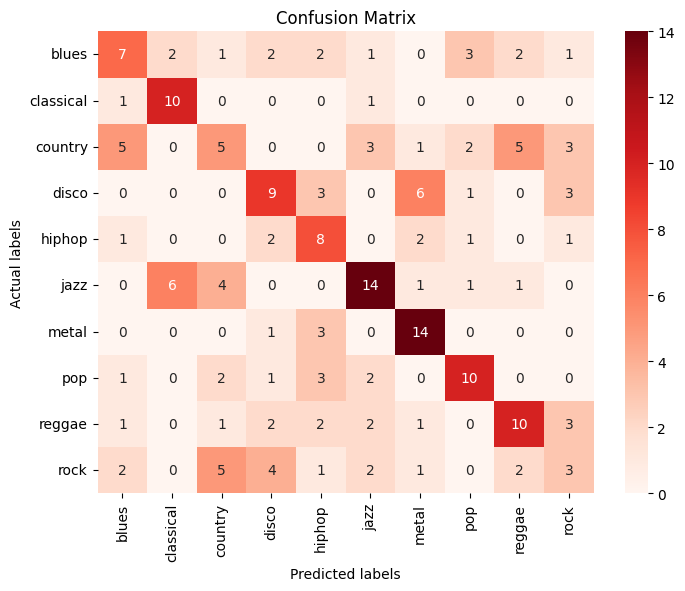

In [ ]:
# Define your model
N_ESTIMATOR = grid_search.best_params_['n_estimators']
LEARNING_RATE = grid_search.best_params_['learning_rate']
xgb = XGBClassifier(n_estimators=N_ESTIMATOR, learning_rate=LEARNING_RATE)

# Train
xgb.fit(X_train, y_train)

# Test the model using one chosen metric
preds = xgb.predict(X_test)
print(classification_report(y_test, preds))
print('Accuracy', ':', accuracy_score(y_test, preds))

# Compute and plot the confusion matrix
plot_confusion_matrix(y_test, preds, categories)

# 4. Pretrained model

The library below is a great source that possibly covers a proposed pretrained model selected. 

[Pytorch pretrained models](https://pytorch.org/vision/stable/models.html)

In [ ]:
# Define data transformations and split the dataset into train and test

# Define relevant variables for the task
BATCH_SIZE = 32
NUM_CLASSES = len(categories)
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Use transforms.compose method to reformat images for modeling
transform = transforms.Compose([
  transforms.ToTensor()
])

# Step 1: Create ImageFolder and apply transforms
dataset = ImageFolder(root=images_original,
                      transform=transform)

# Step 2: Define the size of train and test subsets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Step 3: Split the dataset train and test subsets
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset=dataset,
                                           lengths=[train_size, test_size],
                                           generator=generator)

# Step 4: Create DataLoader from the dataset
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True)

In [ ]:
# Pretrained models and pretrained weights
import torchvision.models as models

class Net(nn.Module):
    def __init__(self, num_classes: int):
        super(Net, self).__init__()

        # Load a pretrained ResNet-18 model
        self.resnet = models.resnet18(pretrained=True)

        # Modify the last layer to match the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        # Forward pass through the pretrained ResNet-18 model
        x = self.resnet(x)
        return x

In [ ]:
def train_model(model: torch.nn.Module,
                device: torch.device,
                optimizer: torch.optim.Optimizer,
                criterion: torch.nn.Module,
                train_loader: torch.utils.data.DataLoader,
                num_epochs: int,
                learning_rate: float) -> None:
  """
  Trains the given model using the provided data loaders.

  Parameters:
    model (torch.nn.Module): The neural network model to be trained.
    device (torch.device): The device to run the training on (CPU or GPU).
    optimizer (torch.optim.Optimizer): The optimizer to use for training.
    criterion (torch.nn.Module): The loss function criterion.
    train_loader (torch.utils.data.DataLoader): DataLoader for training data.
    num_epochs (int): Number of epochs for training.
    learning_rate (float): Learning rate for optimizer.

  Returns:
    None
  """
  # Set the model to training mode
  model.train()
  for epoch in range(num_epochs):
    running_loss = 0.0
    # Training loop: Load in the data using the train_loader object
    for inputs, labels in tqdm(train_loader, leave=False):
      # Move tensors to the configured device
      inputs, labels = inputs.to(device), labels.to(device)
      # Zero the parameter gradients
      optimizer.zero_grad()
      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      # Backward and optimize
      loss.backward()
      optimizer.step()
      # Cumulate loss per epoch
      running_loss += loss.item() * inputs.size(0)

    # Calculate the average loss during training per epoch
    train_loss = running_loss / len(train_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

In [ ]:
def evaluate_model(model: torch.nn.Module,
                   device: torch.device,
                   test_loader: torch.utils.data.DataLoader) -> tuple:
  """
  Evaluates the given model using the provided data loader.

  Parameters:
    model (torch.nn.Module): The neural network model to be evaluated.
    device (torch.device): The device to run the evaluation on (CPU or GPU).
    test_loader (torch.utils.data.DataLoader): DataLoader for test/validation data.

  Returns:
    tuple: A tuple containing lists of actual labels and predicted labels.
  """
  # Set the model to evaluation mode
  model.eval()
  actual_labels = []
  predicted_labels = []
  # no need to calculate any gradients
  with torch.no_grad():
    # Evaluation loop: Load in the data using the test_loader object
    for inputs, labels in tqdm(test_loader, leave=False):
      # Move tensors to the configured device
      inputs, labels = inputs.to(device), labels.to(device)
      # Forward pass
      outputs = model(inputs)

      # Get actual and predicted labels
      _, predicted = torch.max(outputs, 1)
      actual_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(predicted.cpu().numpy())

  return actual_labels, predicted_labels

In [ ]:
# Initialize the model
model = Net(num_classes=NUM_CLASSES)

# Device will determine whether to run the training on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Move model to the configured device
model.to(device)

# Summarize the model architecture
torchsummary.summary(model, (3, 288, 432))

# Define loss function
# CrossEntropyLoss common loss function in PyTorch for training classification
criterion = nn.CrossEntropyLoss()

# Define optimizer
# Adam good performance with little hyper-parameter tuning
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 100MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 144, 216]           9,408
       BatchNorm2d-2         [-1, 64, 144, 216]             128
              ReLU-3         [-1, 64, 144, 216]               0
         MaxPool2d-4          [-1, 64, 72, 108]               0
            Conv2d-5          [-1, 64, 72, 108]          36,864
       BatchNorm2d-6          [-1, 64, 72, 108]             128
              ReLU-7          [-1, 64, 72, 108]               0
            Conv2d-8          [-1, 64, 72, 108]          36,864
       BatchNorm2d-9          [-1, 64, 72, 108]             128
             ReLU-10          [-1, 64, 72, 108]               0
       BasicBlock-11          [-1, 64, 72, 108]               0
           Conv2d-12          [-1, 64, 72, 108]          36,864
      BatchNorm2d-13          [-1, 64, 72, 108]             128
             ReLU-14          [-1, 64, 

In [ ]:
# Train
train_model(model=model,
            device=device,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            num_epochs=NUM_EPOCHS,
            learning_rate=LEARNING_RATE)

Epoch [1/10], Train Loss: 1.5109


Epoch [2/10], Train Loss: 0.9432


Epoch [3/10], Train Loss: 0.7696


Epoch [4/10], Train Loss: 0.5294


Epoch [5/10], Train Loss: 0.4069


Epoch [6/10], Train Loss: 0.3954


Epoch [7/10], Train Loss: 0.3531


Epoch [8/10], Train Loss: 0.2349


Epoch [9/10], Train Loss: 0.1483


Epoch [10/10], Train Loss: 0.1004


In [ ]:
# Save pretrained weights
FILEPATH = f'{dataset_dirs[0]}/Data/pretrained.pth'
torch.save(model.state_dict(), FILEPATH)

In [ ]:
# Test the model using the same chosen metric as your own model
actual_labels, predicted_labels = evaluate_model(model=model,
                                                 device=device,
                                                 test_loader=test_loader)

In [ ]:
# Test using your choosen metric
print(classification_report(y_true=actual_labels,
                            y_pred=predicted_labels,
                            target_names=categories))
accuracy = accuracy_score(y_true=actual_labels,
                          y_pred=predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

              precision    recall  f1-score   support

       blues       1.00      0.20      0.33        20
   classical       1.00      1.00      1.00        16
     country       0.76      0.65      0.70        20
       disco       0.83      0.40      0.54        25
      hiphop       0.39      1.00      0.56        19
        jazz       0.41      0.91      0.56        22
       metal       1.00      0.94      0.97        18
         pop       0.80      0.70      0.74        23
      reggae       1.00      0.48      0.65        21
        rock       0.67      0.25      0.36        16

    accuracy                           0.65       200
   macro avg       0.79      0.65      0.64       200
weighted avg       0.78      0.65      0.64       200

Accuracy: 0.6450


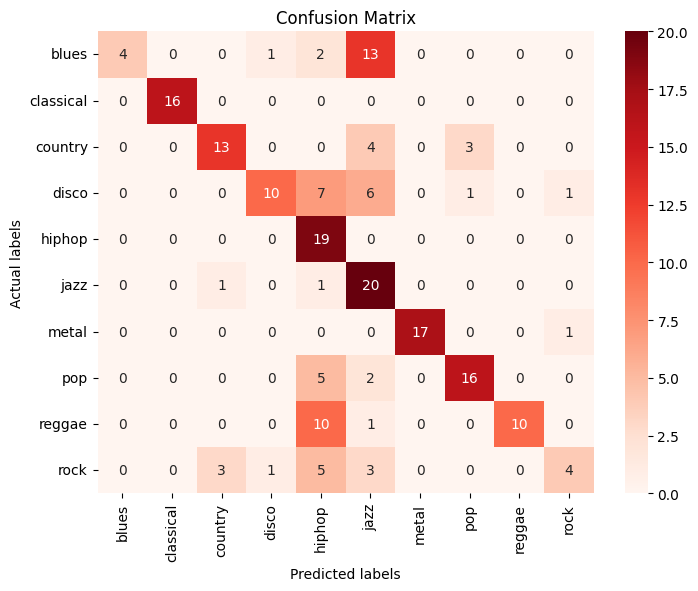

In [ ]:
# Compute and plot the confusion matrix
plot_confusion_matrix(actual_labels, predicted_labels, categories)

# 5. Comparisons

🎧🎸 Compare the proposed model and the pretrained model in terms of performance? Is the model doing a better/worse job than the pretrained model? Why?
Describing confusion matrices is neccessary to answer this question.
Include other metrics, such as accuracy, train-time, etc.

📻🎹

1.   **Accuracy Comparison:** Accuracy is a valid metric to assess model performance, especially when dealing with a balanced dataset. If the pretrained model achieved a higher accuracy compared to the selected XGBoost model, it indicates that the pretrained model's predictions aligned more closely with the ground truth labels. Which is true in our case as the pretrained ResNet18 model, around 0.65 accuracy, outperformed the proposed XGBoost classifier at 0.45 accuracy.

2.   **Interpreting Confusion Matrices:** Confusion matrices provide a detailed breakdown of the model's predictions compared to the actual labels.
Each cell in the confusion matrix represents the number of instances where the predicted class aligns with the actual class (true positives and true negatives) or where they do not align (false positives and false negatives).
Analyzing the confusion matrices allows for a deeper understanding of the models' strengths and weaknesses in classifying different classes. In both the proposed and pretrained model, we observe the diagonal relationship between actual and predicted cases, which demonstrates some accuracy in the model is being achieved.

3.   **Train-Time Reduction:** Train-time reduction is a consideration, particularly in scenarios where model training needs to be completed quickly or with limited computational resources. If the XGBoost model trained significantly faster than the pretrained ResNet18 model, it highlights a notable advantage in terms of efficiency.

4.   **Overall Assessment:** While the pretrained model may have exhibited superior accuracy, the trade-off in terms of train-time reduction with the XGBoost model is essential to consider. If the XGBoost model's accuracy was reasonably close to that of the pretrained model and trained much faster, it may still be a viable option depending on the specific requirements of the task and the available resources.

5.   **Further Considerations:** It's worth investigating why the pretrained model achieved higher accuracy. This could be due to factors such as the inherent capabilities of the pretrained CNN architecture to extract features relevant to the task, the quality and quantity of the training data used to train the CNN, or other architectural differences between the models.
Additionally, exploring avenues to improve the XGBoost model's performance, such as hyperparameter tuning or feature engineering, may help bridge the accuracy gap between the models. In summary, while the pretrained ResNet18 model may have performed better in terms of accuracy, the significant reduction in train-time offered by the XGBoost model is a valuable consideration. It's important to weigh these factors against the specific requirements and constraints of the project to determine the most suitable model such as CPU runtime and memory storage capacity.

🎧🎸 What can be done differently? Why?
> In terms of the dataset, preproccessing, modeling, etc.

📻🎹

To improve the model's performance and address the observed differences between the pretrained model and the XGBoost model, several strategies can be considered:

*   **Feature Engineering:** Explore additional features such as extraction of harmonics and percussive, or transformations that may enhance the predictive power of the selected model such as changing the inner dimension of the features extracted and combinations of spectrogam images. Conduct a thorough analysis of the dataset to identify potential features that could better capture the underlying patterns in the data.

*   **Hyperparameter Tuning:** Perform more extensive hyperparameter tuning for the XGBoost model, considering a broader range of hyperparameter values and techniques such as random search or Bayesian optimization. Experiment with different combinations of hyperparameters to find the optimal configuration that maximizes accuracy. The random forest classification model was also another promising model to be selected.

*   **Ensemble Methods:** Experiment with ensemble methods other than the Voting Classifier, such as stacking or blending, to leverage the strengths of multiple models and potentially improve performance. Combining the strengths of CNNs onto of a classifier model using both images and extracted audio features.

*   **Transfer Learning:** Explore the possibility of using transfer learning with the pretrained ResNet18 model. Fine-tuning the pretrained model on the specific task data or extracting features from intermediate layers of the model could lead to improved performance. We selected ResNet18 as the smallest model and hoping it was the quickest to train, however, there are plenty of other pretrained models such as AlexNet, EfficientNet, VGG, just to name a few. Moreover, even ResNet itself is a base class containing ResNet18, ResNet34, ResNet50, and so on.

*   **Data Augmentation:** Apply data augmentation techniques to increase the diversity of the training data and improve the model's ability to generalize to unseen examples. Techniques such as random cropping of the spectrograms, rotation, and flipping can help generate additional training samples without collecting new data. This may also include audio data augmentation techniques aim to increase the diversity of the training data by introducing variations that preserve the original semantic content. Here are just a few examples:
  * *Time Stretching:* Altering the duration of the audio clip while preserving its pitch and timbre.
  * *Pitch Shifting:* Changing the pitch of the audio without affecting its duration.
  * *Noise Injection:* Adding background noise to audio clips.
  * *Time and Frequency Masking:* Selectively masking certain portions of the spectrogram representation of the audio.
  * *Dynamic Range Compression:* Altering the loudness levels of the audio.
  * *Speed Perturbation:* Introducing variations in the playback speed of the audio.
  * *Room Impulse Response Simulation:* Simulating different room impulse responses.
  * *SpecAugment:* Applying random time and frequency masks to the spectrogram representation of the audio.

*   **Cross-Validation Strategies:** Experiment with different cross-validation strategies, such as stratified k-fold cross-validation or nested cross-validation, to obtain more reliable estimates of model performance and ensure robustness.

All done! 🎶💃🕺

## 6. Optional challenge!🎺

As the model can classify music genres, the challenge is to have the model listen to a piece of music (e.g., on Spotify) and classify its genre in real-time?

**Hint 01:** ```pyaudio``` is a useful library.

**Hint 02:** Perform the same preproccessing on the live data as as per the model.

**Hint 03:** Put the model into the ```.eval()``` state. Don't forget to save the model weights so that it can be loaded using ```model.load_state_dict(torch.load('MyModel_weights.pth'))```

**Hint 04:** The code block needs to listen to the music playing, so maybe put it in a ```try: while True:``` and ```except KeyboardInterrupt``` loop.

In [ ]:
import pyaudio
import numpy as np
import librosa
import torch

CHUNK = 1024
FORMAT = pyaudio.paFloat32  # Adjusted the format to be consistent with np.frombuffer() conversion
CHANNELS = 1  # Adjusted to mono as most models accept mono input
SAMPLING_RATE = 22050
RECORD_SECONDS = 5

# Function to preprocess audio data
def preprocess_audio(y, sr):
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
  tempo = librosa.beat.tempo(y=y, sr=sr)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  # Combine features into a single array
  features = np.concatenate([np.expand_dims(i,axis=0) for i in [chroma_stft.mean(),
                             spectral_rolloff.mean(),
                             spectral_centroid.mean(),
                             np.mean(tempo),
                             mfcc.mean()]])
  return features

# Function to classify genre from audio features
def classify_genre(features, model):
  # Convert features to PyTorch tensor
  features_tensor = torch.tensor(features).unsqueeze(0).float()
  # Perform model inference
  with torch.no_grad():
    model.eval()
    output = model(features_tensor)
  # Get predicted genre label
  predicted_label = torch.argmax(output, dim=1).item()
  return predicted_label

# Load pre-trained model
model = Net(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(FILEPATH))
model.eval()

# Initialize PyAudio
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=SAMPLING_RATE,
                input=True,
                frames_per_buffer=CHUNK)

try:
  print("Listening for audio...")
  while True:
    # Read audio data from stream
    data = stream.read(CHUNK)
    # Convert audio data to numpy array
    audio_np = np.frombuffer(data, dtype=np.float32)
    # Preprocess audio data
    features = preprocess_audio(audio_np, SAMPLING_RATE)
    # Classify genre
    predicted_genre = classify_genre(features, model)
    print("Predicted genre:", predicted_genre)
except KeyboardInterrupt:
  print("Stopped listening...")
  stream.stop_stream()
  stream.close()
  p.terminate()

In [ ]:
# Reference: https://colab.research.google.com/gist/Anwarvic/e843ed55c550784aa6f78faa505ca3ff/colab_mic.ipynb

from io import BytesIO
from base64 import b64decode
from google.colab import output
from IPython.display import Javascript

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=30):
  print("Speak Now...")
  display(Javascript(RECORD))
  sec += 1
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Done Recording !")
  b = b64decode(s.split(',')[1])
  return b #byte stream

In [ ]:
audio = record(5)

In [ ]:
import IPython.display as ipd
ipd.display(ipd.Audio(audio))

In [ ]:
# Default FFT window size
block_length = 32
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns
y = librosa.stream(audio, block_length=block_length, frame_length=n_fft, hop_length=hop_length)

SAMPLING_RATE = 22050
audio_np = np.frombuffer(audio, dtype=np.uint8)
data = audio_np.astype(np.uint8)
data = data / 255 # Now scale by 255
y = data.astype(np.float64)

# Preprocess audio data
features = preprocess_audio(y, SAMPLING_RATE)
df = pd.DataFrame(features, columns=feature_names)
df
# Classify genre
predicted_genre = classify_genre(features, model)
print("Predicted genre:", predicted_genre)